# MOGUNTIA DATA ASSIMILATION exercises

---------
<FONT COLOR=red>

# Part 1: Optimizing the land sink of CO$_2$

<FONT COLOR=black> 

----------

##### Wouter Peters, December 2021
##### Wouter Peters, modifications for ICOS Summerschool, May 2023

    
##### version 2.0

### Goal

* Quantify the mismatch between observations and model, understand the L1 and L2 norm (Exercise 4)
* Understand the role of a cost function, and learn to construct it (Exercise 5)
* Apply the minimum least-squares solution and understand the role of observation uncertainty (Exercise 6)
    

<div class="alert alert-block alert-info">
<b>Tip:</b> 

You can go through this practical at your own pace: 

 1. For a novice user, it is fine to just read the instructions, execute the cells, and try to answer the questions. Sometimes you might need to modify a value in the code and run a cell multiple times. In that case focus on the part of the cell that looks like this:

```python
1| ############### YOUR INPUT BELOW ################
2| 
3| SomeVariable = [1,2,3  <--- You make a change    
4|    
5| ############### YOUR INPUT ENDS ################                      
```                            
 
 2. For a regular user, it might be nice to read and understand the python code in the cells. In that case look at the parts indicated by:
  
```python 
1| ############### PYTHON CODE STARTS BELOW ################    
```

 3. Expert users are challenged to also modify and write code to explore the material further   
</div>

      


## Introduction to Exercise 4 and 5



The optimal land uptake found in Exercise 3 was determined by trial and error, and by judging the difference to the 
observations using the human eye. In data assimilation this "forward modeling" of the problem is very important. It 
gives the researcher a good feeling for the system, and helps build an expectation of the outcome of a more formal optimization 
process. Once the forward modeling yields a satisfactory system, an optimization algorithm can be used to fine-tune 
the solution and find the numerically best values for a set of unknowns.

Often, the best numerical solution is one that best reproduces observations, quantified by for example the root-mean-square-error (RMSE):

<div class="alert alert-block alert-warning">


$ RMSE=\sqrt{\frac{1}{(N-1)}\sum (y^{0}-H(x))^2 } $     .........(Equation 1)

with:

$y^{0}$ = Observations [ppm]

$x$ = the unknown scaling factor for the land-sink [-]

$H$ = a linear operator on $x$ that makes it comparable to $y^{0}$: MOGUNTIA

$H(x)$ = MOGUNTIA calculated value of the CO$_2$ mole fraction given $x$ [ppm]

$N$ = number of observations
    
</div>   
    
We often tend to say that the value of the land sink $x$ that is "optimal", is the one that minimizes the RMSE to observations ($y^{0}$) once run through the MOGUNTIA model ($H$). The RMSE is an example of a so-called L2-norm, in which deviations from the observed value are weighted in quadrature. If we had used the absolute difference:

<div class="alert alert-block alert-warning">

$ \frac{1}{(N-1)}\sum(| y^{0}-H(x) |) $ .........(Equation 2)
</div>   

this would have put less emphasis on larger deviations. We call this an L1-norm. 
    
 

**In Exercise 4, we will calculate the L1 and L2 norm for the solutions you created in Exercise 3.**

In [1]:
#### PLEASE EXECUTE THIS CELL ONCE UPON STARTUP, IT LOADS A SET OF NEEDED PYTHON LIBRARIES ####


%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpda
import seaborn as sns

%matplotlib inline

<P><FONT COLOR=darkblue>

In the cell below, you can investigate the two metrics above (RMSE and J) in the runs you did so far. There is also one output file already made for you, which holds the x$_{a}$ from the minimum least squares method. Its value for the global land sink is close to 2.1 as used in simulation `fixedsink.in`. 

---
<div class="alert alert-block alert-warning">
<b>To do</b> 
    
<FONT COLOR=red>

* Inspect the cell, and see if you understand the Python code provided. 

* Print the values of the ABME and RMSE and cost function for some of the runs you've done. Can you recognize the "best" simulation from the metrics? 

* How does the metric depend on the set of observations you include in the set? Try to add an "independent" site to the set that makes the RMSE go very high. 

</FONT>
</div>  

Absolute mean error    : 0.976784 [ppm]   
Root-mean-square error : 1.230258 [ppm]  


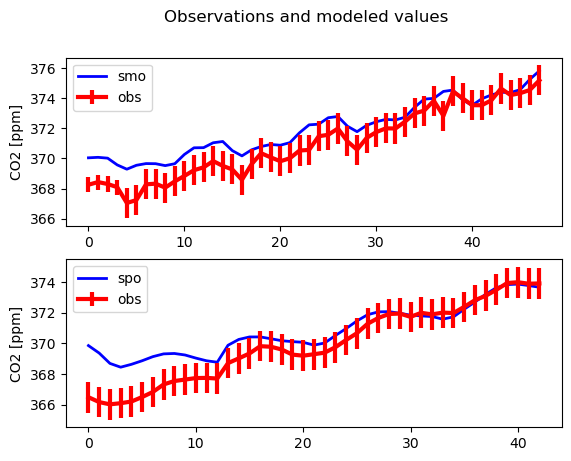

In [9]:
############### YOUR INPUT BELOW ################


############################# Define a set of sites to assess with our metrics: ############################

obsset = ['smo','spo']

############################# Get the observations and modeled values for a given experiment ############################

y,Hx,info = mpda.get_concentrations('FOSSIL3',obsset)


############### YOUR INPUT ENDS ################

############################ Compute the metrics ############################

ABME = np.abs((y-Hx)).mean()   # make L1 for this run
RMSE = np.sqrt(((y-Hx)**2).mean())    # make RMSE for this run

print(f'Absolute mean error    : {ABME:f} [ppm]   ')
print(f'Root-mean-square error : {RMSE:f} [ppm]  ')

############################# plot the outcomes per site ############################

fig, axs = plt.subplots(len(obsset))
fig.suptitle('Observations and modeled values')

istart=0
for i,site in enumerate(obsset):
    nn=info[site]
    iend=istart+nn
    
    axs[i].plot(np.arange(nn),Hx[istart:iend],lw=2,color='blue',label=site)
    axs[i].errorbar(np.arange(nn),y[istart:iend],yerr=np.sqrt(R.diagonal()[istart:iend]),lw=3,color='red',label='obs')
    axs[i].legend()
    axs[i].set_ylabel('CO2 [ppm]')

    istart+=nn


---------
<FONT COLOR=red>

# Part 2: Optimizing multiple paramaters with a Kalman filter

<FONT COLOR=black> 

----------

### Goal

* Learn the role of a prior mean and uncertainty and expand the cost function (Exercise 6)
* Know how to apply and interpret the Kalman filter solution for multiple parameters (Exercise 7)
* Understand how the transport model affects the solution of an Ensemble Kalman Filter (Exercise 8)